# Within-host $\pi_W$

This code examines the frequency distribution of within-host nucleotide diversity $\pi_W$ in samples taken from malaria-infected individuals around the world.
* We find that $\pi_W$ has a strikingly bimodal distribution (scroll down to see plots showing this).
* We postulate that one of the peaks (with high $\pi_W$) represents hosts that have been superinfected, or who lie on a transmission chain where there is cotransmission following a recent episode of superinfection.
* We postulate that the other peak (with low $\pi_W$) represents transmission chains where there has been no recent superinfection or cotransmission.  
* We can use the low $\pi_W$ peak to estimate the quantum of transmission with the formula $Q = \pi_W / 2 \mu$.

#### About the data

Data are from the [MalariaGEN Pf6 dataset](https://www.malariagen.net/resource/26) which has data on 6,051,696 variants in 7,113 samples from 30 countries. This notebook uses files that we have created based on:
* Selected variants that are high-quality biallelic coding SNPs (n = 502,221). High quality means 'filter_pass == True' & 'vqslod > 3'
* Selected samples that passed QC (n = 5,970)
* Data on allele depth for reference and non-reference forms of these biallelic SNPs in individual samples, from which we have calculated within-host heterozygosity for each SNP in each sample.

Elsewhere we show [an analysis of the SNPs that are heterozygous in samples with low $\pi_W$](https://d-kwiat.github.io/gtg/pi_w_checks.html) as a sanity check to exclude the possibility that the low $\pi_W$ peak is a technical artefact due to systematic genotyping errors.  

#### We will use these files

**These files are not currently available via Google Colab so this notebook is for info only** 

`wiho_het.npy`
* Gives within-host heterozygosity for each SNP (n = 502,221) in each sample (n = 5,970).  
* As we have selected biallelic SNPs this is easy to calculate from allele depth data.
* Filename: `230318_wiho_het.npy`
* This is a large file - 11.7GB - so it takes a while to process

`region`
* A list of geographical regions for 5,970 selected samples
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania
* Filename: `230316_region`

`het_per_snp`
* Mean within-host heterozygosity for each SNP, calculated from `wiho_het.npy`
* Filename: `230317_het_per_snp`

`het_per_sample`
* Mean within-host heterozygosity for each sample after filtering by SNP heterozygosity (typically <0.02) and by geographical region.
* Filenames:
  * All regions (5970 samples): `230317_het_per_sample_ALL`
  * Southeast Asia: `230316_het_per_sample_SEA`
  * Africa (3314 samples): `230317_het_per_sample_Africa`

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Colab Data/Pf6/"

Mounted at /content/drive


In [ ]:
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import statistics as stat

In [ ]:
selected_snps = 502221
selected_samples = 5970

#### Create `snp_filter` to filter out possible hyperhets
* Here we use het < 0.02 as our criterion for inclusion 

In [ ]:
with open(data_path + "230317_het_per_snp", "r") as fp:
    het_per_snp = json.load(fp)

snp_filter = []

for i in range(selected_snps):
    
    if het_per_snp[i] < 0.02:
        
        snp_filter.append(True)
    
    else:
        snp_filter.append(False)
        
filtered_snps = snp_filter.count(True)
        
print('This includes', str(filtered_snps), 'SNPs')

This includes 496459 SNPs


#### Create `sample_filter` to select a particular geographical region
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [ ]:
with open(data_path + "230316_region", "r") as fp:
    region = json.load(fp)

sample_filter = []

for i in range(selected_samples):
    
    if region[i] == "CAF" or region[i] == "EAF" or region[i] == "WAF":
        
        sample_filter.append(True)
        
    else:
        
        sample_filter.append(False)
        
filtered_samples = sample_filter.count(True)
    
print('This includes', str(filtered_samples), 'samples')

This includes 3314 samples


#### Calculate mean heterozygosity per sample after filtering samples and SNPs
* Creates a list of het values, one for each selected & filtered sample 
* This is the mean het for selected & filtered SNPs and not for all nucleotide positions
* On Colab this should take approximately 15 minutes depending on the selection of regions
* Save the output for future use

In [ ]:
wiho_het = np.load(data_path + '230318_wiho_het.npy', mmap_mode = 'r')

het_per_sample = []

for i in range(selected_samples):
    
    if sample_filter[i] == True:

        het = []
    
        for j in range(selected_snps):
    
            if snp_filter[j] == True: 
            
                het.append(wiho_het[j, i])
    
        y = stat.mean(het)
    
        het_per_sample.append(y)
    
    if i % 10 == 0:
        
        print(i)
        
with open(data_path + "230317_het_per_sample_Africa", "w") as filepath:
    json.dump(het_per_sample, filepath)

#### Plot histogram of within-host nucleotide diversity

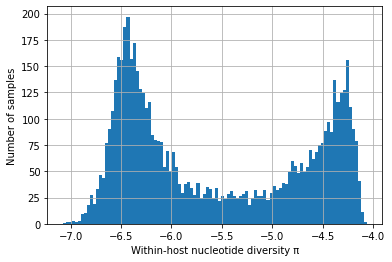

In [ ]:
# All regions - only SNPs with het < 0.02

with open(data_path + "230317_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

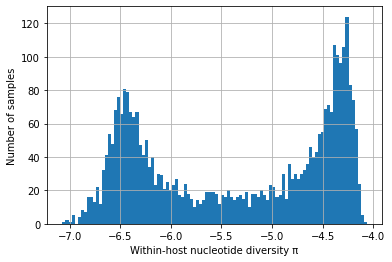

In [ ]:
# Africa - only SNPs with het < 0.02

with open(data_path + "230317_het_per_sample_Africa", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

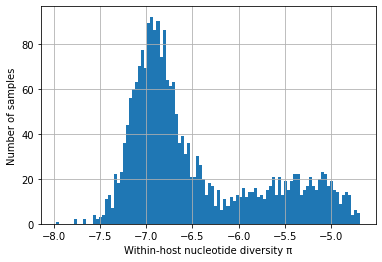

In [ ]:
# Southeast Asia - only SNPs with het < 0.02

with open(data_path + "230316_het_per_sample_SEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()